In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import sklearn.metrics as mt
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import RFE
#import warnings
#warnings.filterwarnings('ignore')
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

In [3]:
# import 2018Q2 data

data_q1=pd.read_csv('LoanStats_2016Q1.csv',skiprows=1,header=0) #2016Q1
data_q2=pd.read_csv('LoanStats_2016Q2.csv',skiprows=1,header=0) #2016Q2
data_q3=pd.read_csv('LoanStats_2016Q3.csv',skiprows=1,header=0) #2016Q3
data_q4=pd.read_csv('LoanStats_2016Q4.csv',skiprows=1,header=0) #2016Q4

frames = [data_q1, data_q2, data_q3, data_q4]

data_df = pd.concat(frames,sort=True)

FileNotFoundError: File b'LoanStats_2016Q1.csv' does not exist

In [4]:
def Preprocess_Data(data_df,save_mod=False):
    # drop irrelevant predictors such as id and url (also description because we do not plan to do text mining)
    data1=data_df.drop(['member_id','id','desc','url'], axis=1)
    
    # Keep only 'Fully Paid' or 'Charged Off'
    # The reason for doing this early is to save some memory 
    data1= data1[(data1["loan_status"] == "Fully Paid") | (data1["loan_status"] == "Charged Off")]
 
    # drop columns that contain missing values more than 1% of the rows
    col=data1.columns
    Na_in_col = pd.isnull(data1).sum()
    for i in range(len(col)):
        if Na_in_col[i] > data1.shape[0]*0.01:
            data1=data1.drop(col[i], axis=1)
            
    col=data1.columns # renew 
    
    # drop columns that may leak information     
    drop_leak = ['funded_amnt','funded_amnt_inv','issue_d','out_prncp','out_prncp_inv',
                 'total_pymnt','total_pymnt_inv','total_rec_prncp','total_rec_int', 'total_rec_late_fee',
                 'recoveries', 'collection_recovery_fee', 'last_pymnt_d','last_pymnt_amnt',
                 'last_fico_range_high','last_fico_range_low'
                ]
    for column in drop_leak:
        if column in col:
            data1 = data1.drop(column,axis=1)

    # drop columns that contain redundant information
    drop_redundant = ['sub_grade', 'int_rate','zip_code','title']
    for column in drop_redundant:
        if column in col:
            data1 = data1.drop(column,axis=1)
    
    
    # drop columns that require too much preprocessing to become a valid predictors
    drop_troublesome = ['emp_title','earliest_cr_line','initial_list_status',
                        'addr_state','last_credit_pull_d']
    for column in drop_troublesome:
        if column in col:
            data1 = data1.drop(column,axis=1)
    
    # drop columns with only one value
    data1= data1.loc[:,data1.apply(pd.Series.nunique) != 1]
    
    
    #Again, there may be some columns with more than one unique values 
    #but one of the values has insignificant frequency in the dataset. Let's find out and drop such column(s)
    for col in data1.columns:
        if (len(data1[col].unique()) < 4):
            tmp = data1[col].value_counts() 
            tmp = tmp/sum(tmp) # convert each counts into percentage
            if sum(tmp > 0.95) >= 1: # if there is 1 values that predominant (more than 95%)
                data1 = data1.drop(col, axis=1)

    mapping_dictionary = {"loan_status":{ "Fully Paid": 1, "Charged Off": 0}}
    data1= data1.replace(mapping_dictionary)
                
   # Drop rows that contain NA
    data1 = data1.dropna()
            
   # Format revol_util (remove % and change into float)
    if 'revol_util' in data1.columns:
        data1['revol_util'] = data1['revol_util'].str.rstrip('%').astype('float')
        
    # Convert ordinary data 
    mapping_dict = {
        "grade":{
            "A": 1,
            "B": 2,
            "C": 3,
            "D": 4,
            "E": 5,
            "F": 6,
            "G": 7
        }
    }

    data1 = data1.replace(mapping_dict)
    
    
    
    # Convert categorical columns using one-hot-coding
    nominal_columns = ['home_ownership', 'verification_status', 'purpose', 
                       'term', 'disbursement_method', 'application_type']
    for col in nominal_columns:
        if col in data1.columns:
            dummy_df = pd.get_dummies(data1[col])
            data1 = pd.concat([data1, dummy_df], axis=1)
            data1 = data1.drop(col, axis=1)
   
    # new feature 
    data1['installment_feat'] = data1['installment'] / (data1['annual_inc'] / 12)
    
    if save_mod:
        #save clean data
        data1.to_csv("data_cleaned_shujian.csv",index=False)
    
    return  data1

Above is shujian's data processing code.

In [5]:
data1 = pd.read_csv("data_cleaned_shujian.csv")

In [6]:
data1.columns

Index(['acc_now_delinq', 'acc_open_past_24mths', 'all_util', 'annual_inc',
       'avg_cur_bal', 'chargeoff_within_12_mths', 'collections_12_mths_ex_med',
       'delinq_2yrs', 'delinq_amnt', 'dti', 'fico_range_high',
       'fico_range_low', 'grade', 'inq_fi', 'inq_last_12m', 'inq_last_6mths',
       'installment', 'loan_amnt', 'loan_status', 'max_bal_bc',
       'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl',
       'mort_acc', 'num_accts_ever_120_pd', 'num_actv_bc_tl',
       'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl',
       'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats',
       'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'open_acc',
       'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m',
       'open_rv_12m', 'open_rv_24m', 'pct_tl_nvr_dlq', 'pub_rec',
       'pub_rec_bankruptcies', 'revol_bal', 'revol_util', 'tax_liens',
       'tot_coll_amt', 'tot_cur_bal', 'tot_hi_cred_lim', 'total_acc',
       '

Draw the correlation matrix, delete abs>0.7 variables

In [8]:
# Correlation >0.7
col_names = data1.corr().columns.values
for col, row in ((data1.corr().abs() > 0.7) & (data1.corr().abs() < 1)).iteritems():
    print(col, col_names[row.values])


acc_now_delinq ['num_tl_30dpd']
acc_open_past_24mths ['num_tl_op_past_12m' 'open_rv_24m']
all_util []
annual_inc []
avg_cur_bal ['tot_cur_bal' 'tot_hi_cred_lim']
chargeoff_within_12_mths []
collections_12_mths_ex_med []
delinq_2yrs []
delinq_amnt []
dti []
fico_range_high ['fico_range_low']
fico_range_low ['fico_range_high']
grade []
inq_fi []
inq_last_12m []
inq_last_6mths []
installment ['loan_amnt']
loan_amnt ['installment']
loan_status []
max_bal_bc []
mo_sin_old_rev_tl_op []
mo_sin_rcnt_rev_tl_op []
mo_sin_rcnt_tl []
mort_acc []
num_accts_ever_120_pd []
num_actv_bc_tl ['num_actv_rev_tl' 'num_bc_sats' 'num_rev_tl_bal_gt_0']
num_actv_rev_tl ['num_actv_bc_tl' 'num_op_rev_tl' 'num_rev_tl_bal_gt_0']
num_bc_sats ['num_actv_bc_tl' 'num_bc_tl' 'num_op_rev_tl']
num_bc_tl ['num_bc_sats' 'num_rev_accts']
num_il_tl []
num_op_rev_tl ['num_actv_rev_tl' 'num_bc_sats' 'num_rev_accts' 'num_rev_tl_bal_gt_0'
 'num_sats' 'open_acc']
num_rev_accts ['num_bc_tl' 'num_op_rev_tl' 'total_acc']
num_rev_tl_b

In [9]:
drop_col = ['num_tl_30dpd','open_rv_12m','open_rv_24m','installment', 'num_actv_rev_tl',
            'num_bc_sats','num_rev_tl_bal_gt_0','num_rev_accts',"num_sats",'open_acc',
            'total_bal_ex_mort', 'total_il_high_credit_limit','total_rev_hi_lim',
            'avg_cur_bal' ,'tot_hi_cred_lim','RENT','open_il_24m','acc_open_past_24mths','open_acc_6m'," 60 months"]
data1= data1.drop(drop_col,axis = 1) 

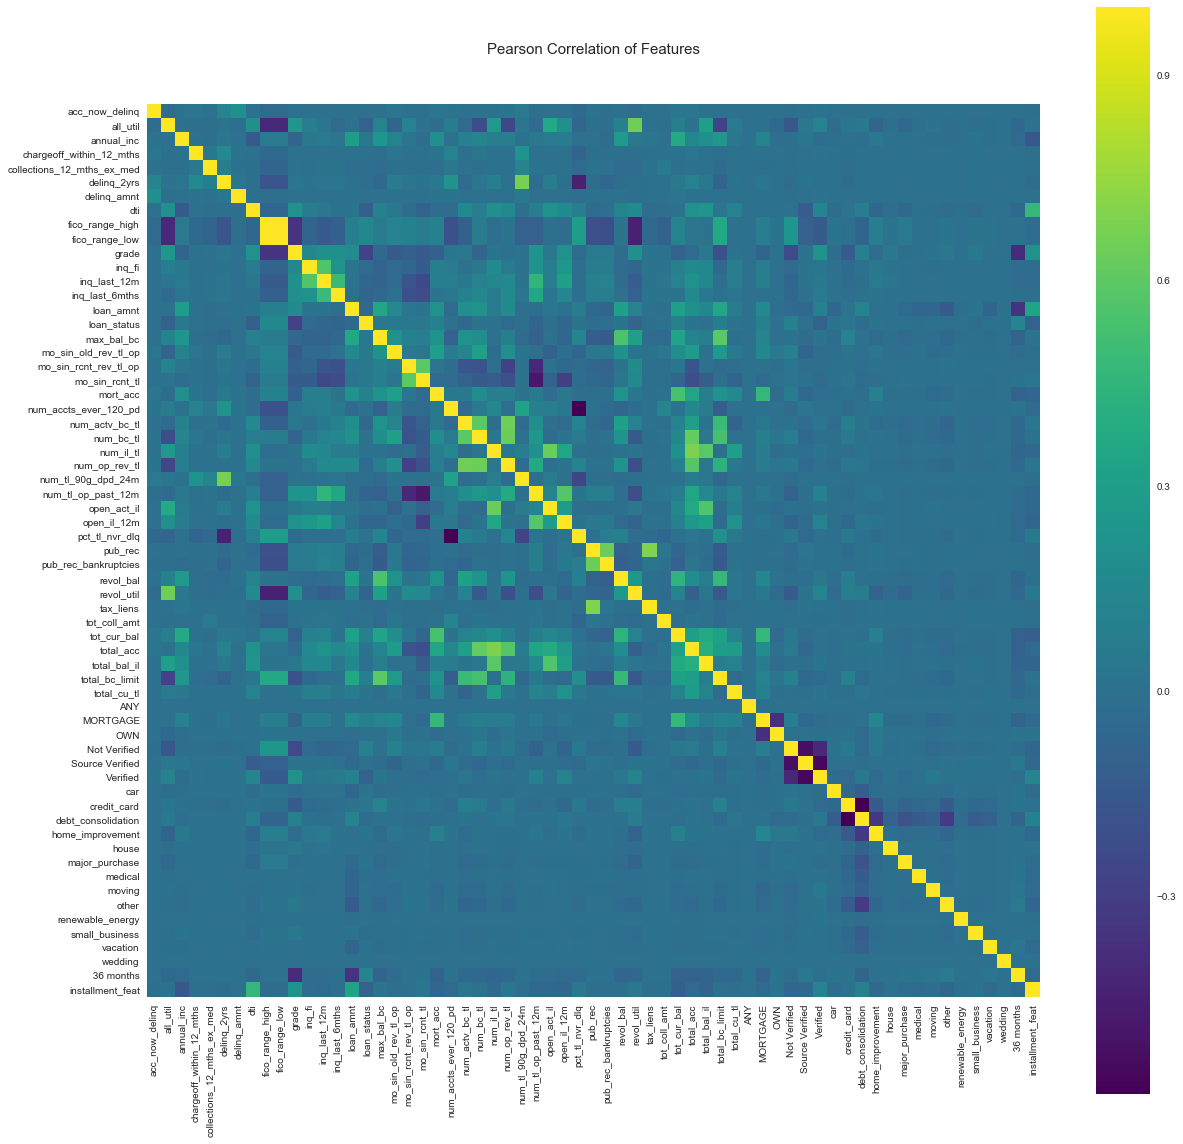

In [10]:
# Plot correlation matrix after deleting

colormap = plt.cm.viridis
plt.figure(figsize=(20,20))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(data1.corr(), square=True, cmap=colormap, linecolor='white');

In [11]:
data1.shape

(226894, 63)

In [12]:
y = data1["loan_status"]
X = data1.iloc[:, data1.columns != 'loan_status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


In [13]:
## Try random forest

#Training

rf_model = RandomForestClassifier(n_estimators= 100, max_depth = 20)
rf_model.fit(X_train, y_train)

#Predict
rf_pred_train = rf_model.predict(X_train)
rf_pred_test = rf_model.predict(X_test)

#Perfromance Evaluation
rf_train_score = accuracy_score(y_train, rf_pred_train)*100
rf_test_score = accuracy_score(y_test, rf_pred_test)*100

print("Random Forest Accuracy on Training Set :",str(rf_train_score)+'%')
print("Random Forest Accuracy on Testing Set :",str(rf_test_score)+'%')

Random Forest Accuracy on Training Set : 93.26942676913754%
Random Forest Accuracy on Testing Set : 75.30796183256572%


In [14]:
# Logistic regression(balanced)
from sklearn.linear_model import LogisticRegressionCV
# first scale
std_scaler = MinMaxScaler() 
X_train = std_scaler.fit_transform(X_train)
X_test = std_scaler.transform(X_test)

lr_balanced = LogisticRegressionCV(multi_class="ovr",cv = 5, penalty='l2', max_iter=1000, class_weight = 'balanced')
lr_balanced.fit(X_train,y_train)
y_balanced_pred = lr_balanced.predict(X_test)
print(accuracy_score(y_test,y_balanced_pred))

0.6537385134092862


In [15]:
## Feature selection  1

lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(X_train, y_train)
model = SelectFromModel(lsvc, prefit=True)
X_new = model.transform(X_train)
X.columns[model.get_support()]

Index(['dti', 'fico_range_high', 'grade', 'inq_last_6mths', 'loan_amnt',
       'mo_sin_rcnt_rev_tl_op', 'mort_acc', 'num_actv_bc_tl', 'num_bc_tl',
       'num_il_tl', 'num_op_rev_tl', 'num_tl_op_past_12m', 'open_il_12m',
       'pct_tl_nvr_dlq', 'revol_util', 'tot_cur_bal', 'total_bc_limit',
       'total_cu_tl', 'MORTGAGE', 'OWN', 'Not Verified', 'Source Verified',
       'credit_card', 'debt_consolidation', 'medical', 'other',
       'small_business', ' 36 months'],
      dtype='object')

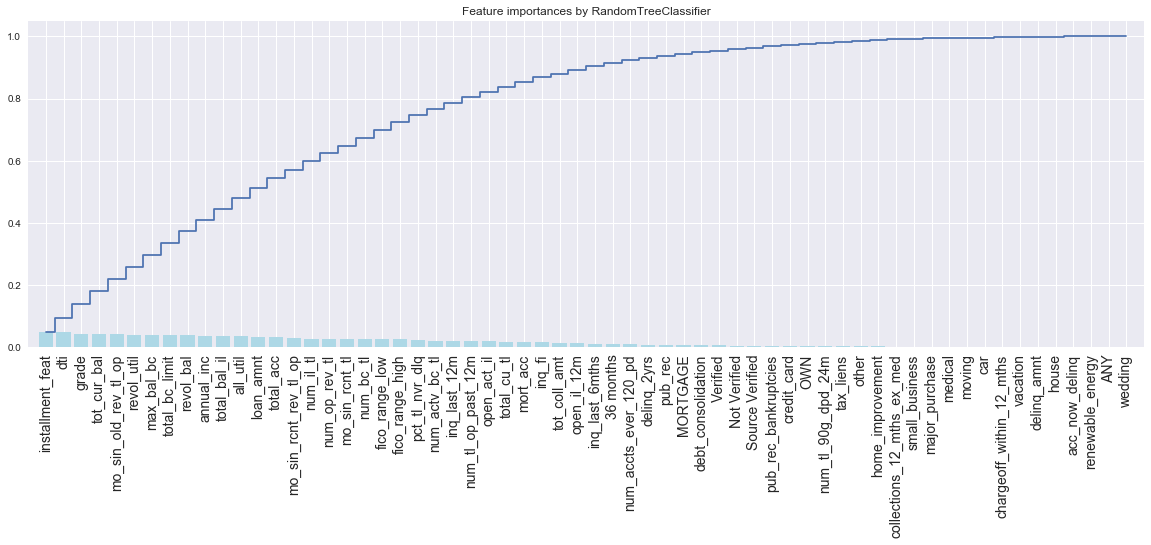

In [16]:
## Feature selection  2

clf=RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)

importances = clf.feature_importances_
feat_names = X.columns
indices = np.argsort(importances)[::-1]
fig = plt.figure(figsize=(20,6))
plt.title("Feature importances by RandomTreeClassifier")
plt.bar(range(len(indices)), importances[indices], color='lightblue',  align="center")
plt.step(range(len(indices)), np.cumsum(importances[indices]), where='mid', label='Cumulative')
plt.xticks(range(len(indices)), feat_names[indices], rotation='vertical',fontsize=14)
plt.xlim([-1, len(indices)])
plt.show()

In [17]:
# Select feature based on 1 and 2

select_col = ['installment_feat', 'dti', 'tot_cur_bal', 'grade',
       'mo_sin_old_rev_tl_op', 'revol_util', 'total_bc_limit', 'max_bal_bc',
       'revol_bal', 'annual_inc', 'all_util', 'total_bal_il', 'loan_amnt',
       'total_acc', 'mo_sin_rcnt_rev_tl_op', 'num_il_tl', 'num_op_rev_tl',
       'mo_sin_rcnt_tl', 'num_bc_tl', 'pct_tl_nvr_dlq', 'num_actv_bc_tl',
       'inq_last_12m', 'num_tl_op_past_12m', 'open_act_il', 'total_cu_tl',
       'mort_acc', 'inq_fi', 'tot_coll_amt', 'inq_last_6mths', 'open_il_12m',
       'num_accts_ever_120_pd', 'delinq_2yrs', 'pub_rec', ' 36 months',
       'MORTGAGE', 'debt_consolidation', 'Verified','Not Verified']


In [18]:
# Creat new selected X

final_drop = list(set(X.columns)-set(select_col))
X_select = X.drop(final_drop,axis=1)     
X_select.shape

(226894, 38)

In [19]:
X_train_select, X_test_select, y_train_select, y_test_select = train_test_split(X_select,
                                                                                y, test_size=0.2)


In [20]:
## Logistic regression(balanced)

std_scaler = MinMaxScaler() 
X_train_select_S = std_scaler.fit_transform(X_train_select)
X_test_select_S = std_scaler.transform(X_test_select)


lr_balanced = LogisticRegressionCV(multi_class="ovr",cv = 5, penalty='l2', max_iter=1000, class_weight = 'balanced')

lr_balanced.fit(X_train_select_S,y_train_select)
y_balanced_pred = lr_balanced.predict(X_test_select_S)
print(accuracy_score(y_test_select,y_balanced_pred))

0.6563388351440094


Build single tree, see the accuracy and find the depth.

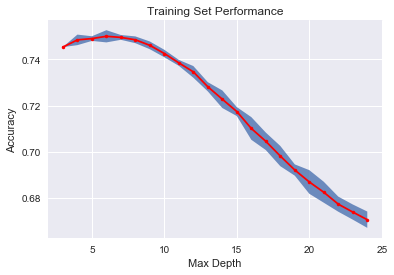

In [21]:
depth = []
score = []
score_std = []
for i in range(3,25):
    DT = DecisionTreeClassifier(max_depth=i)
    # 5-fold cross validation 
    scores = cross_val_score(estimator= DT, X=X_train_select, y=y_train_select, cv=5)
    depth.append(i)
    score.append(scores.mean())
    score_std.append(scores.std())
plt.plot(depth, np.array(score), 'r.-')
plt.fill_between(depth, np.array(score) - 2*np.array(score_std), np.array(score) + 2*np.array(score_std),alpha =0.8)
plt.ylabel("Accuracy")
plt.xlabel("Max Depth")
plt.title("Training Set Performance")
plt.show()

In [22]:
## Random Forest (robust to outlier and scale, doesn't matter if it is scaled 


#Training
rf_model = RandomForestClassifier(n_estimators= 100, max_depth = 20)
rf_model.fit(X_train_select, y_train_select)

#Predict
rf_pred_train = rf_model.predict(X_train_select)
rf_pred_test = rf_model.predict(X_test_select)

#Perfromance Evaluation
rf_train_score = accuracy_score(y_train_select, rf_pred_train)*100
rf_test_score = accuracy_score(y_test_select, rf_pred_test)*100

print("Random Forest Accuracy on Training Set :",str(rf_train_score)+'%')
print("Random Forest Accuracy on Testing Set :",str(rf_test_score)+'%')

Random Forest Accuracy on Training Set : 94.63570503815112%
Random Forest Accuracy on Testing Set : 75.51069878137464%


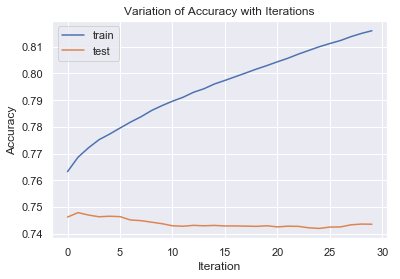

In [69]:
#Fit an Adaboost Model

ada_model = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=10), 
                               n_estimators=30, learning_rate=0.05)
ada_model.fit(X_train, y_train)

#Plot Iteration based score
train_scores = list(ada_model.staged_score(X_train,y_train))
test_scores = list(ada_model.staged_score(X_test, y_test))

plt.plot(train_scores,label='train')
plt.plot(test_scores,label='test')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title("Variation of Accuracy with Iterations")
plt.legend();

In [21]:
## Try undersampling （loan status 1:1）

length = len(data1[data1.loan_status == 0])
status1_indices = data1[data1.loan_status == 1].index
random_indices = np.random.choice(status1_indices,length, replace=False)
status0_indices = data1[data1.loan_status == 0].index
under_sample_indices = np.concatenate([status0_indices,random_indices])
under_sample = data1.loc[under_sample_indices]
#under_sample = under_sample.drop(select_col,axis = 1) 
under_sample_y = under_sample["loan_status"]
under_sample_X = under_sample.iloc[:, under_sample.columns != 'loan_status']
X_train_u, X_test_u, y_train_u, y_test_u = train_test_split(under_sample_X,under_sample_y, 
                                                            test_size=0.2)





In [22]:
## Random Forest 


#Training
rf_model = RandomForestClassifier(n_estimators= 200, max_depth = 20)
rf_model.fit(X_train_u, y_train_u)

#Predict
rf_pred_train = rf_model.predict(X_train_u)
rf_pred_test = rf_model.predict(X_test_u)

#Perfromance Evaluation
rf_train_score = accuracy_score(y_train_u, rf_pred_train)*100
rf_test_score = accuracy_score(y_test_u, rf_pred_test)*100

print("Random Forest Accuracy on Training Set :",str(rf_train_score)+'%')
print("Random Forest Accuracy on Testing Set :",str(rf_test_score)+'%')


Random Forest Accuracy on Training Set : 99.11792718299493%
Random Forest Accuracy on Testing Set : 65.52813852813853%


Looks like it is better not to undersample(oversample is not necessary since we have a lot of data)

#NEW MODEL USING BALANCED DATA#

In [31]:
## LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
#Training
LDA_model = LinearDiscriminantAnalysis()
LDA_model.fit(X_train, y_train)
#predict
LDA_pred_train=LDA_model.predict(X_train)
LDA_pred_test=LDA_model.predict(X_test)
#Performance Evaluation
LDA_train_score=accuracy_score(y_train, LDA_pred_train)*100
LDA_test_score=accuracy_score(y_test, LDA_pred_test)*100

print("LDA Accuracy on Training Set :",str(LDA_train_score)+'%')
print("LDA Accuracy on Testing Set :",str(LDA_test_score)+'%')

LDA Accuracy on Training Set : 75.43178249731427%
LDA Accuracy on Testing Set : 75.01267105930056%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


In [30]:
## QDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
#Training
QDA_model = QuadraticDiscriminantAnalysis()
QDA_model.fit(X_train, y_train)
#predict
QDA_pred_train=QDA_model.predict(X_train)
QDA_pred_test=QDA_model.predict(X_test)
#Performance Evaluation
QDA_train_score=accuracy_score(y_train, QDA_pred_train)*100
QDA_test_score=accuracy_score(y_test, QDA_pred_test)*100

print("QDA Accuracy on Training Set :",str(QDA_train_score)+'%')
print("QDA Accuracy on Testing Set :",str(QDA_test_score)+'%')

/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


QDA Accuracy on Training Set : 25.992342230669642%
QDA Accuracy on Testing Set : 26.164084708786%


In [1]:
##KNN classifier
from sklearn.neighbors import KNeighborsClassifier
#Training
KNN_model = KNeighborsClassifier(n_neighbors=100)
KNN_model.fit(X_train,y_train)
#predict
KNN_pred_train=KNN_model.predict(X_train)
KNN_pred_test=KNN_model.predict(X_test)
#performance Evaluation
KNN_train_score=accuracy_score(y_train, KNN_pred_train)*100
KNN_test_score=accuracy_score(y_test, KNN_pred_test)*100

print("KNN Accuracy on Training Set :",str(KNN_train_score)+'%')
print("KNN Accuracy on Testing Set :",str(KNN_test_score)+'%')

NameError: name 'X_train' is not defined

future: 
1. first try to improve the model accuracy (and sensitivity, specificity)
2. if we cannot, move on to build a cost model based on the probability we get